## Project Overview
Predicting churn rates is a very challenging and common problem that data scientists and analysts face in any customer-facing business. They have to ascertain it before so that steps can be taken to prevent users from churning.
The goal of this project was to help Sparkify music service retain their customers. 

The main task of the project is to make a prediction, whether the customer is about to churn. Such a prediction can be made for each customer by a binary classifier model. The following tasks should be completed to create the model:
1. Analyze and preprocess the data to extract usable features for each customer
2. Train classifier and then evaluate it

## Metrics

As we will see further that the class set in this case is imbalanced, the number of customers who churned is three times less that the one who did not. So, accuracy will not be a good metric here. I choose F1 score as it will give weightage to both false positives and false negatives. False Positives is important because we would not want to spend money on a customer who will not churn, False Negatives is important because failure to detect them would lead to loss of customers.  

In [1]:
# adding PySpark to sys.path at runtime
import findspark
findspark.init()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import re


In [3]:
# import libraries for spark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, DateType, IntegerType
from pyspark.sql.functions import concat, lit, avg, split, isnan, when, count, col, sum, mean, stddev, min, max, round, udf, to_date, datediff 
from pyspark.sql import Window

from pyspark.ml.feature import StringIndexer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.util import MLUtils

In [4]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("spark_app") \
    .getOrCreate()

# Processing Dataset
Load and clean dataset `mini_sparkify_event_data.json`, checking for invalid or missing data. The file can be downloaded here : https://github.com/celestinhermez/sparkify_customer_churn/blob/master/mini_sparkify_event_data.json

This is the smaller data to test on our local machine. 

It contains events like every activity that a user does on the app (any click)

In [5]:
mini_sparkify_event_data = r'C:\Users\shubh\Data_Science\Projects\Credit-Card\mini_sparkify_event_data.json'

In [6]:
df = spark.read.json(mini_sparkify_event_data)

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Input Space Definition

Description of the input dataset:

|#| Column | Type | Description |
| --- | --- | --- | --- |
| 1 | userId | string | Unique identifier of the user|
| 2 | artist | string | Name of the artist related to the song related to the event |
| 3 | auth | string | authentication of the customer : whether he is logged in or not |
| 4 | firstName | string | First name of the user |
| 5 | gender | string | Gender of the user |
| 6 | itemInSession | bigint | Item in session |
| 7 | lastName | string | Last name of the user |
| 8 | length | double | Length of the song related to the event |
| 9 | level | string | Whether the account is free or paid. User can change the level, so events for the same user can have different levels |
| 10 | location | string | Location of the user |
| 11 | method | string | Get method or Put method |
| 12 | page | string | Type of action which corresponds to the event : this can be clicking "Next Song", "Upvoting" etc |
| 13 | registration | bigint | Registration |
| 14 | sessionId | bigint/long| Session id|
| 15 | song | string | Name of the song related to the event |
| 16 | status | bigint/long | Response status from the page: 200, 404, 307 |
| 17 | ts | bigint/long | Timestamp of the event |
| 18 | userAgent | string | The browser used and other relevant information eg: Mozilla/5.0 |

## Clean Dataset

`1.` Check for missing values:

In [7]:
'''
nan values are the ones which are not a number , a result of division by zero or something invalid. Null values are empty values.
'''
columns = df.describe().columns[1:]
empy_vals = {}
for column in columns:
    empy_vals[column] = df.select('userId').where((isnan(column)) | (col(column).isNull())).count() 



In [8]:
empy_vals

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

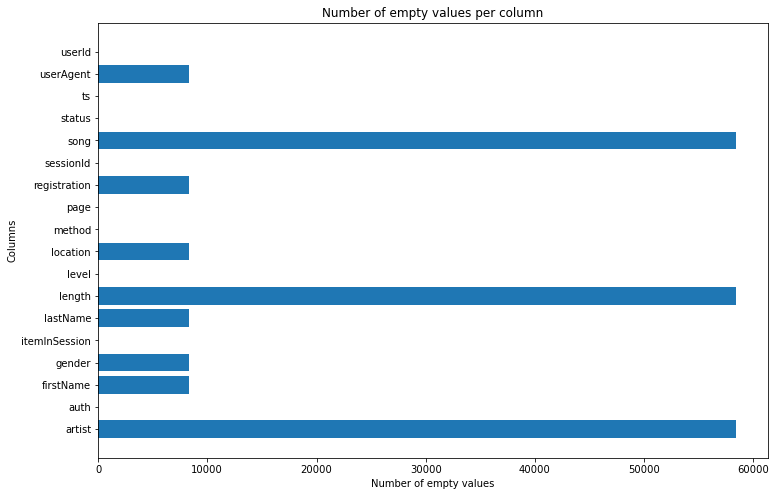

In [9]:

fig,ax = plt.subplots(1, figsize=(12,8))

ax.barh(np.arange(len(empy_vals)), width= list(empy_vals.values()), align='center')

ax.set_yticks(np.arange(len(empy_vals)))
ax.set_yticklabels(empy_vals.keys())

plt.title('Number of empty values per column')
plt.ylabel('Columns')
plt.xlabel('Number of empty values')   

plt.show()

There are exactly the same numbers of missing values for some of the columns. This may mean that some columns are not filled in for specific kind of events.

In [10]:
# These are the columns having null values

df.select(['userId','page', 'userAgent', 'registration', 'location', \
           'firstName', 'lastName', 'gender', 'song', 'length', 'artist']).where(isnan(df['firstName']) | df['firstName'].isNull()).show()
# .where(isnan(df['firstName']) | df['firstName'].isNull()).show()

+------+-----+---------+------------+--------+---------+--------+------+----+------+------+
|userId| page|userAgent|registration|location|firstName|lastName|gender|song|length|artist|
+------+-----+---------+------------+--------+---------+--------+------+----+------+------+
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      | Help|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      | Home|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  null|  null|
|      |Login|     null|        null|    null|     null|    null|  null|null|  n

In [11]:
df.select(['userId']).where(df['location'].isNull()).count()

8346

The rows with empty `userId`, which correspond to users, who are not signed in, have null values for `userAgent, registration, location, firstName, lastName, gender, song, length and artist` columns.

Other rows with empty `song, artist and length` columns probably correspond to other events, which are not related to listening to music, for example, upgrade or downgrade events. Let's look closer at the `page` column values corresponding to rows with empty `song, artist and length` columns.

In [12]:
# select page column values where song, artist and length columns are not null
df.select(['page']).where(df['song'].isNotNull() & df['length'].isNotNull() & df['artist'].isNotNull())\
.groupby('page').count().show()

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



We see that `song, artist and length` columns are filled in only for `NextSong` event.

`2.` Check for empty strings in string type colums:

In [13]:
# define list of columns with String type
columns_str = ['artist', 'auth', 'firstName', \
               'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']

In [14]:
# for each column with type string find number of empty string values
empy_str_vals = []
for column in columns_str:
    empy_str_vals.append(df.select(['userId']).where(df[column] == '').count())

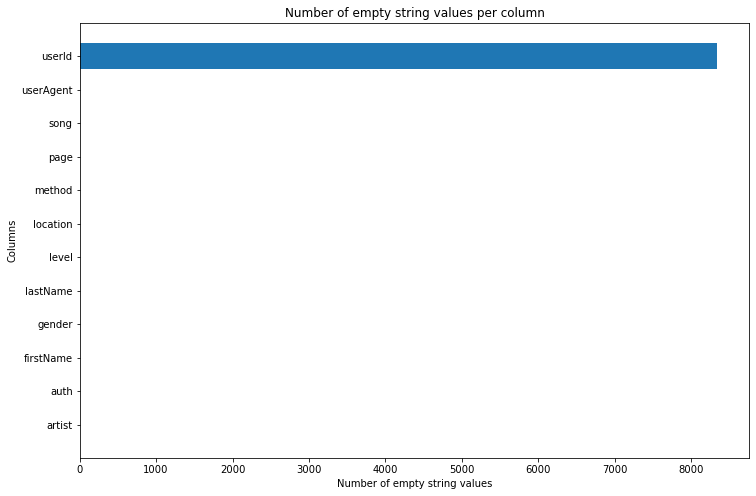

In [15]:
fig, ax = plt.subplots(1, figsize=(12,8))    

ind = np.arange(len(empy_str_vals))
ax.barh(ind, empy_str_vals)
ax.set_yticks(ind)
ax.set_yticklabels(columns_str, minor=False)

plt.title('Number of empty string values per column')
plt.ylabel('Columns')
plt.xlabel('Number of empty string values')      

plt.show()

There is no `userId` for rows where user has not logged in, we have to predict customer churn, therefore we can omit these rows

`3.` Check for invalid values in numeric columns:

In [16]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [17]:
df.describe(['itemInSession', 'length', 'sessionId', 'registration','status', 'ts']).show()

+-------+------------------+-----------------+-----------------+--------------------+------------------+--------------------+
|summary|     itemInSession|           length|        sessionId|        registration|            status|                  ts|
+-------+------------------+-----------------+-----------------+--------------------+------------------+--------------------+
|  count|            286500|           228108|           286500|              278154|            286500|              286500|
|   mean|114.41421291448516|249.1171819778458|1041.526554973822|1.535358834084427...|210.05459685863875|1.540956889810483...|
| stddev|129.76726201140994|99.23517921058361|726.7762634630741| 3.291321616327586E9| 31.50507848842214|1.5075439608226302E9|
|    min|                 0|          0.78322|                1|       1521380675000|               200|       1538352117000|
|    max|              1321|       3024.66567|             2474|       1543247354000|               404|       1543799

we see numeric columns don't have any invalid values.

`4.` __Perform data cleaning__: the following function removes rows with empty `userId` from the dataset.

In [18]:
def clean_data(df):
    
    df_new = df.filter(df["userId"] != "")
    
    return df_new


df = clean_data(df)

# print out first line
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [19]:
# count after removal of users not logged in
df.count() 

278154

# Exploratory Data Analysis

Exploratory data analysis for mini dataset, which is the subset of full dataset.

## 1. Preliminary Analysis

Analyze categorical columns ('auth', 'gender', 'level', 'method', 'page'):

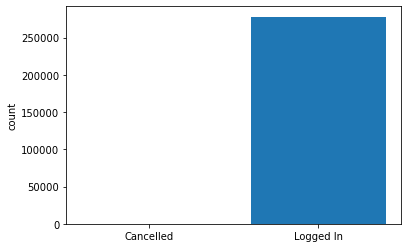

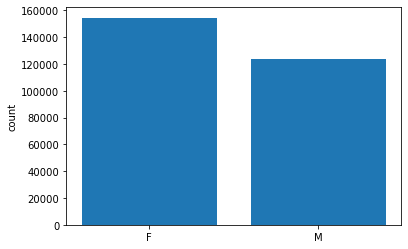

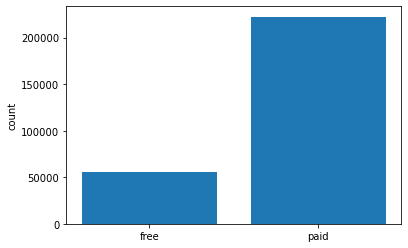

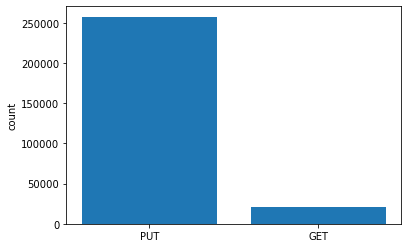

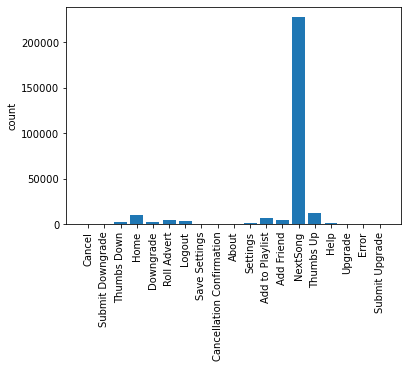

In [20]:

cat_columns = ['auth', 'gender', 'level', 'method','page']


for i in cat_columns:
    temp = df.select([i, 'userId']).groupby(i).agg(count('userId')).toPandas()
    fig, ax = plt.subplots(figsize=(6,4))
    if len(list(temp[i]))>7:
        ax.bar(list(temp[i]), height=list(temp['count(userId)']))
        ax.set_xticklabels(list(temp[i]), rotation=90)
    else:   
        ax.bar(list(temp[i]), height=list(temp['count(userId)']))
    ax.set_ylabel('count')
    


The plot above shows us the following about the small dataset:
1. The number of events for female users is slightly greater than for male users. This may be true only for our small dataset which is the subset of the full dataset.
2. The number of events for paid level accounts is approximately 4 times greater than the number of events for free level accounts.
3. The most popular action is `NextSong` as that is the most common user action on a music app
4. Most of the events are for Logged in Users

In [21]:
# calculate the number of female and male users

male = df.select('userId', 'gender').where(df.gender == 'M').groupBy('userId').count().agg(count("count"))
female = df.select('userId', 'gender').where(df.gender == 'F').groupBy('userId').count().agg(count("count"))

print('There are {male} male and {female} female users in dataset.'\
      .format(male = male.collect()[0]["count(count)"],\
             female = female.collect()[0]["count(count)"]))

There are 121 male and 104 female users in dataset.


In [22]:
# total number of distinct users by gender

df.select('gender', 'userId').distinct().groupby('userId','gender').count().groupby('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



In [23]:
# total number of distinct users by type of account : free or paid

df.select('level', 'userId').distinct().groupby('userId','level').count().groupby('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



We see that the total number of accounts we calculated `(165 + 195 = 360)` is greater than total amount of users `(121 + 104 = 225)`. This happened because one user can upgrade/downgrade his account, so when grouping by users we can get more records in total than the number of users.

The table above tells us:
1. There are slightly more male users in mini dataset. But comparing with the previous plot where we saw more events for female users, we can say that female users are more active than male users
2. There are slightly more free accounts in mini dataset, but there are more events for paid users. This leads to a conclusion that users with paid accounts are lot more active (engage with the app).

## 2. Defining Churn

Create a column `churn` to label users who cancelled subscription and and mark rows for the users, who cancelled subscription, with `churn = 1`.

In [24]:
cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", cancellation_event("page"))

In [25]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [26]:
df.select('page').where(col('page')=='Cancellation Confirmation').count()

52

In [27]:
# get userId of the ones who churn
cancelled_users = df.select(['userId']).where(df.churn == 1).groupby('userId').count().toPandas()['userId'].values

In [28]:
cancelled_users

array(['125', '51', '54', '100014', '101', '29', '100021', '87', '73',
       '3', '28', '100022', '100025', '300007', '100006', '18', '70',
       '100005', '17', '100007', '300001', '100009', '100015', '200024',
       '100003', '103', '100024', '53', '122', '200017', '58', '100011',
       '100019', '100012', '200018', '200016', '200020', '106', '143',
       '32', '200001', '105', '200011', '100023', '100013', '100017',
       '121', '12', '200015', '129', '200021', '100001'], dtype=object)

In [29]:
# set churn == 1 for all rows for users who cancelled their subscription
def fill_array(userId, features):
    if(userId in cancelled_users): return 1
    else : return 0

fill_array_udf = udf(fill_array, IntegerType())

df = df.withColumn("churn", fill_array_udf(col("userId"), col("churn")))

In [30]:
df.select('churn').where(col('churn')==1).count()

44864

## 3. Explore Data

Perform exploratory data analysis to observe the behavior for users who stayed vs users who churned.

`3.1` Explore number of users who churned vs number of users who stayed with the service:

In [31]:
# find the number of users who churned and who stayed
churned_users = df.select('userId').where(df['churn'] == 1).groupBy('userId').count().count()
stayed_users = df.select('userId').where(df['churn'] == 0).groupBy('userId').count().count()

print('The number of users who churned is {}'.format(churned_users))
print('The number of users who didn\'t cancel subscription is {}'.format(stayed_users))

The number of users who churned is 52
The number of users who didn't cancel subscription is 173


We can see that __the dataset is imbalanced__: number of users who churned is approximately 3 times less than the number of users who stayed. That is why __accuracy is probably not the best metric to evaluate our future machine learning model__. Hence F1 score will be used.

`3.2`  Explore number of events with respect to categorical columns for users who churned and for users who kept subscription:

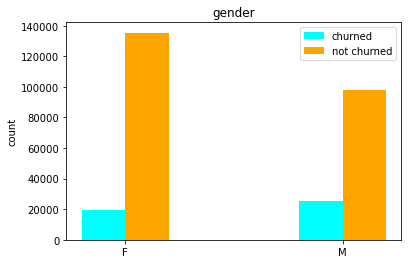

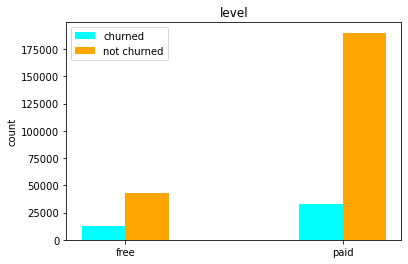

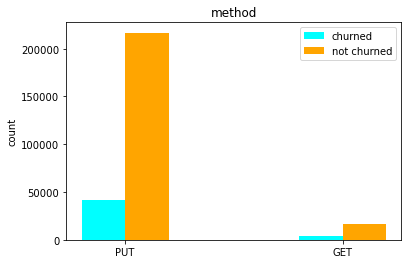

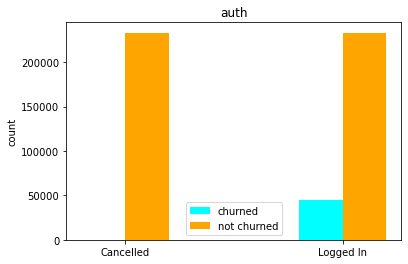

In [32]:
# Now we will compare number of churns categorical column wise
cat_columns = ['gender', 'level', 'method', 'auth']

width=0.2

for i in cat_columns:
    
    temp1 = df.select([c for c in df.columns]).where(col('churn')==1).groupby(i).agg(count(i)).toPandas()
    temp0 = df.select([c for c in df.columns]).where(col('churn')==0).groupby(i).agg(count(i)).toPandas()
    x = np.arange(len(temp1))
    fig, ax = plt.subplots()
    ax.bar(x-0.2, list(temp1.iloc[:,1]),width,color='cyan')
    ax.bar(x, list(temp0.iloc[:,1]),width, color='orange')
    ax.set_xticks([-0.1,0.9])
    ax.set_xticklabels(list(temp1.iloc[:,0]))
    ax.set_ylabel("count")
    ax.set_title(str(i))
    ax.legend(["churned","not churned"])
    plt.show()




The plot above tells us the following:
1. Despite the fact that there are more events for female than male users, number of events for churned male users is greater than for churned female users. That is why we can suppose that female users who churned are less active service users than those who stay with their subscription.


`3.3` Explore the gender of churned users and account level:

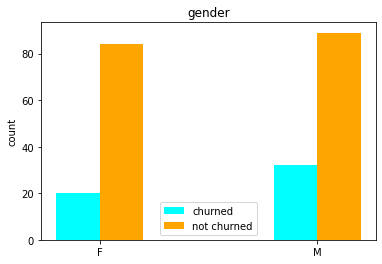

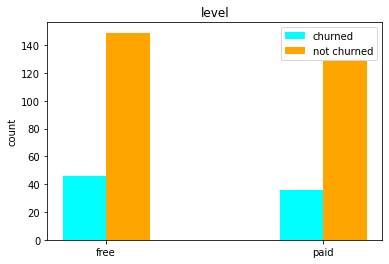

In [33]:
cat_columns = ['gender', 'level']

width=0.2

for i in cat_columns:
    
    temp1 = df.select([c for c in df.columns]).where(col('churn')==1).groupby(i,'UserId').agg(count(i)).groupby(i).agg(count(i)).toPandas()
    temp0 = df.select([c for c in df.columns]).where(col('churn')==0).groupby(i,'UserId').agg(count(i)).groupby(i).agg(count(i)).toPandas()
    x = np.arange(len(temp1))
    fig, ax = plt.subplots()
    ax.bar(x-0.2, list(temp1.iloc[:,1]),width,color='cyan')
    ax.bar(x, list(temp0.iloc[:,1]),width, color='orange')
    ax.set_xticks([-0.1,0.9])
    ax.set_xticklabels(list(temp1.iloc[:,0]))
    ax.set_ylabel("count")
    ax.set_title(str(i))
    ax.legend(["churned","not churned"])
    plt.show()

We notice the following points from the plots above:


1. There are `32 male` and `20 female` users who churned in the dataset.
2. There are `89 male` and `84 female` users who didn't cancel their subscription in the dataset.
3. There are only 52 users who churned and having 82 (36 + 46) accounts related to churned users 
4. This means that 30 of users had both paid and free account levels.
5. There are 129 paid and 149 free accounts related to users who didn't cancel their subscription in the dataset.


`3.4` Explore average song length for users who churned vs users who stayed:

In [34]:
df.select([c for c in df.columns]).where(df.churn==1).select(col('length')).describe().toPandas()[1:3]

,summary,length
1,mean,248.63279564406366
2,stddev,102.38497717575474


In [35]:
df.select([c for c in df.columns]).where(df.churn==0).select(col('length')).describe().toPandas()[1:3]

,summary,length
1,mean,249.20913538881427
2,stddev,98.6258830014688


We see that average song length for users who churned is very close to the average song length for the other users.

`3.5`  Explore userAgent column:

In [36]:
# create a new column for parsed agent 
def get_agent(agent):
    agent = agent.split()[0]
    return re.sub(r'[^\w\s]','',agent)
    
get_agent_udf = udf(get_agent, StringType())
df = df.withColumn('agent', get_agent_udf(col('userAgent')))

In [37]:
# select all agent values
df.select('agent').distinct().show()

+---------+
|    agent|
+---------+
|Mozilla50|
+---------+



We see that the 1st user agent is Mozilla for all users. So this column is not informative for mini dataset.

`3.6` Explore location column:

In [38]:
# create column for state for each event extracting it from location

def get_state(location):
    location = location.split(',')[-1].strip()
    if (len(location) > 2):
        location = location.split('-')[-1].strip()
    
    return location
    
get_state_udf = udf(get_state, StringType())
df = df.withColumn('state', get_state_udf(col('location')))

In [39]:
# Number of distinct states
df.select('state').distinct().count()

39

In [40]:
df.select([c for c in df.columns]).groupby('state').count().orderBy('count', ascending=False).show()

+-----+-----+
|state|count|
+-----+-----+
|   CA|46771|
|   PA|26607|
|   TX|23494|
|   NH|18637|
|   FL|13190|
|   NC|11771|
|   WI| 8697|
|   MD| 8600|
|   SC| 8448|
|   IN| 8230|
|   NJ| 7816|
|   CO| 7493|
|   MI| 7216|
|   IL| 6960|
|   CT| 6720|
|   VA| 6514|
|   WV| 6350|
|   AL| 5573|
|   AZ| 4846|
|   MS| 4634|
+-----+-----+
only showing top 20 rows



From the above table, we can see that California has maximum activity

In [41]:
# calculate number of events for users who churned/stayed for each state

value_counts_ch = df.where(df['churn'] == 1).groupBy('state').count().toPandas().sort_values('state')
value_counts_st = df.where(df['churn'] == 0).groupBy('state').count().toPandas().sort_values('state')

In [42]:
# churned users per state
value_counts_st.reset_index().drop(columns='index')

,state,count
0,AK,3563
1,AL,3471
2,AZ,4595
3,CA,39158
4,CO,3176
5,CT,6720
6,FL,11427
7,GA,4236
8,IA,838
9,ID,317


### `3.6` __Conclusions__:
1. From the exploratory analysis above we learn that behavior of female users is different compairing to behavior of male users:
    * Female users are more active: there are fewer female users, but there are more events related to female users.
    * Percentage of male users who churned is greater than percentage of female users, who churned, so male users may be more likely to churn.
2. Female users who churned have different behavior rather than other female users: female users whi churned are less active users of the service.

# Feature Engineering

We have analysed all the features in the Dataset, Now to predict whether the user is going to churn for each user we will extract the following features:
* __gender__, because EDA showed us that male and female users may have different behavior
* __last level (paid or free)__, because we see that paid level users are more active and also may have different behavior
* __average events per day__ to see how active the user is in general
* __average songs per day__ to see how active the user is in listening to the music
* __number of thumbs up__ to see how satisfied the user is with the content of the service
* __number of thumbs down__ to see how satisfied the user is with the content of the service
* __days since the date of first event__ to see how long the user has already been using the service
* __last location (state)__ the popularity may vary depending on advertising in different regions
* __number of add friend events__ perhaps the user is less likely to churn if his friends are also subscribed to the service.

In [43]:
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, agent='Mozilla50', state='CA')]

In [44]:
def prepare_dataset(df): 
    df = clean_data(df)
    
    cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())   
    df = df.withColumn("churn", cancellation_event("page"))   
    cancelled_users = df.select(['userId']).where(df.churn == 1).groupby('userId').count().toPandas()['userId'].values
    
    def fill_array(userId, features):
        if(userId in cancelled_users): return 1
        else : return 0
    
    fill_array_udf = udf(fill_array, IntegerType())
    df = df.withColumn("churn", fill_array_udf(col("userId"), col("churn")))
    
    w = Window.partitionBy('userId')
    df = df.withColumn('last_ts', max('ts').over(w)) #create last timestamp
    df = df.withColumn('first_ts', min('ts').over(w)) #create first timestamp
    
    def get_date_from_ts(ts):
        return str(datetime.utcfromtimestamp(ts / 1000).strftime('%Y-%m-%d'))
    
    get_date_from_ts_udf = udf(get_date_from_ts, StringType())
    df = df.withColumn('last_date', get_date_from_ts_udf(col('last_ts'))) #converting last timestamp to date
    df = df.withColumn('first_date', get_date_from_ts_udf(col('first_ts'))) #converting first timestamp to date
    
    
    df = df.withColumn('date', get_date_from_ts_udf(col('ts')))
    
    
    df = df.withColumn('last_level',when(df.last_ts == df.ts, df.level))
    
    # create column avg_songs to calculate average number of songs per day
    w = Window.partitionBy('userId', 'date')
    songs = df.where(df.page == 'NextSong').select('userId', 'date', count('userId').over(w).alias('songs')).distinct()
    w = Window.partitionBy('userId')
    songs = songs.withColumn('avg_songs', avg('songs').over(w))
    songs = songs.select(col("userId").alias("songs_userId"), 'avg_songs')
    songs = songs.withColumn("avg_songs", round(songs["avg_songs"], 2))
    
    # create column avg_events to calculate average number of events per day
    w = Window.partitionBy('userId', 'date')
    events = df.select('userId', 'date', count('userId').over(w).alias('events')).distinct()
    w = Window.partitionBy('userId')
    events = events.withColumn('avg_events', avg('events').over(w))
    events = events.select(col("userId").alias("events_userId"), 'avg_events')
    events = events.withColumn("avg_events", round(events["avg_events"], 2))
    
    # calculate number of thumbs up for a user
    w = Window.partitionBy('userId')
    thumbsup = df.where(df.page == 'Thumbs Up').select('userId', count('userId').over(w).alias('thumbs_up')).distinct()
    thumbsup = thumbsup.select(col("userId").alias("thumbsup_userId"), 'thumbs_up')
    
    # calculate number of thumbs down for a user
    w = Window.partitionBy('userId')
    thumbsdown = df.where(df.page == 'Thumbs Down').select('userId', count('userId').over(w).alias('thumbs_down')).distinct()
    thumbsdown = thumbsdown.select(col("userId").alias("thumbsdown_userId"), 'thumbs_down')
    
    # calculate days since the date of the first event
    df = df.withColumn("days_active", 
              datediff(to_date(lit(datetime.now().strftime("%Y-%m-%d %H:%M"))),
                       to_date("first_date","yyyy-MM-dd")))
    
    # add column with state of the event based on location column
    def get_state(location):
        location = location.split(',')[-1].strip()
        if (len(location) > 2):
            location = location.split('-')[-1].strip()
    
        return location
    
    get_state_udf = udf(get_state, StringType())
    df = df.withColumn('state', get_state_udf(col('location')))
    
    #add column with last location of the user
    df = df.withColumn('last_state',when(df.last_ts == df.ts, df.state))
    
    # calculate number of add friends for a user
    w = Window.partitionBy('userId')
    addfriend = df.where(df.page == 'Add Friend').select('userId', count('userId').over(w).alias('addfriend')).distinct()
    addfriend = addfriend.select(col("userId").alias("addfriend_userId"), 'addfriend')

    # assemble everything into resulting dataset
    df_ml = df.select('userId', 'gender', 'churn', 'last_level', 'days_active', 'last_state')\
    .dropna().drop_duplicates()
    df_ml = df_ml.join(songs, df_ml.userId == songs.songs_userId).distinct()
    df_ml = df_ml.join(events, df_ml.userId == events.events_userId).distinct()
    df_ml = df_ml.join(thumbsup, df_ml.userId == thumbsup.thumbsup_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_up'])
    df_ml = df_ml.join(thumbsdown, df_ml.userId == thumbsdown.thumbsdown_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['thumbs_down'])
    df_ml = df_ml.join(addfriend, df_ml.userId == addfriend.addfriend_userId, how='left').distinct()
    df_ml = df_ml.fillna(0, subset=['addfriend'])
    df_ml = df_ml.drop('songs_userId','events_userId', 'thumbsup_userId', 'thumbsdown_userId', 'addfriend_userId')
    
    return df, df_ml
    
df = spark.read.json(mini_sparkify_event_data)
df.persist()

df, df_ml = prepare_dataset(df)

In [45]:
df_ml.count()

225

In [46]:
df_ml.take(1)

[Row(userId='61', gender='M', churn=0, last_level='free', days_active=933, last_state='CA', avg_songs=77.24, avg_events=89.82, thumbs_up=78, thumbs_down=11, addfriend=26)]

Look closer at `days_active, avg_songs,avg_events,thumbs_up,thumbs_down,addfriend` columns for different types of users:

In [47]:
# find days_active for users who churned vs others
churned = df_ml.select("days_active").where(df_ml["churn"] == 1).toPandas()["days_active"].values
stayed = df_ml.select("days_active").where(df_ml["churn"] == 0).toPandas()["days_active"].values

In [48]:
churned

array([925, 933, 934, 931, 923, 934, 934, 931, 934, 931, 934, 934, 934,
       926, 934, 934, 924, 932, 929, 934, 915, 933, 934, 932, 934, 931,
       932, 934, 930, 932, 934, 931, 933, 933, 931, 932, 931, 932, 933,
       934, 932, 932, 933, 932, 934, 933, 934, 929, 933, 923, 934, 934])

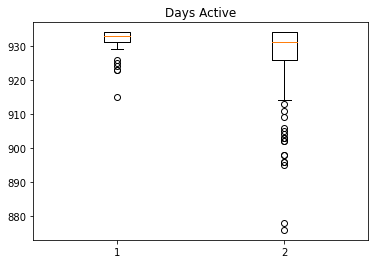

In [50]:
# plot days active churned and stayed
data = [churned, stayed]
fig, ax = plt.subplots()
ax.set_title('Days Active')
ax.boxplot(data)
plt.show()

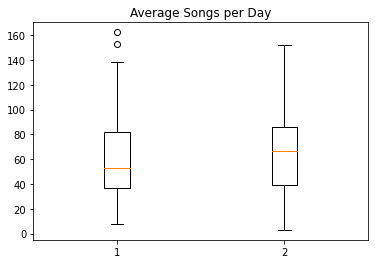

In [51]:
# find avg_songs for users who churned vs others
churned = df_ml.select("avg_songs").where(df_ml["churn"] == 1).toPandas()["avg_songs"].values
stayed = df_ml.select("avg_songs").where(df_ml["churn"] == 0).toPandas()["avg_songs"].values

# plot
data = [churned, stayed]
fig, ax = plt.subplots()
ax.set_title('Average Songs per Day')
ax.boxplot(data)
plt.show()

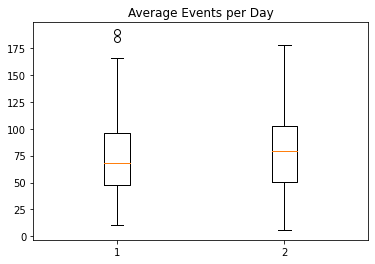

In [52]:
# find avg_events for users who churned vs stayed
churned = df_ml.select("avg_events").where(df_ml["churn"] == 1).toPandas()["avg_events"].values
stayed = df_ml.select("avg_events").where(df_ml["churn"] == 0).toPandas()["avg_events"].values

# plot
data = [churned, stayed]
fig, ax = plt.subplots()
ax.set_title('Average Events per Day')
ax.boxplot(data)


plt.show()

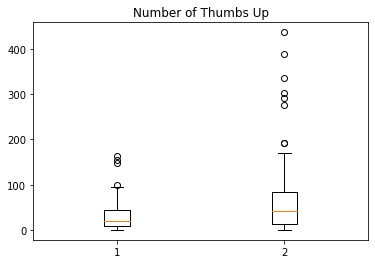

In [53]:
# find thumbs_up for users who churned vs others
churned = df_ml.select("thumbs_up").where(df_ml["churn"] == 1).toPandas()["thumbs_up"].values
stayed = df_ml.select("thumbs_up").where(df_ml["churn"] == 0).toPandas()["thumbs_up"].values

# plot
data = [churned, stayed]
fig, ax = plt.subplots()
ax.set_title('Number of Thumbs Up')
ax.boxplot(data)


plt.show()

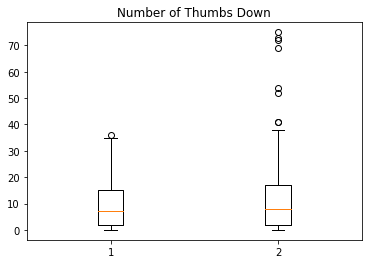

In [54]:
# find thumbs_down for users who churned vs others
churned = df_ml.select("thumbs_down").where(df_ml["churn"] == 1).toPandas()["thumbs_down"].values
stayed = df_ml.select("thumbs_down").where(df_ml["churn"] == 0).toPandas()["thumbs_down"].values

# plot
data = [churned, stayed]
fig, ax = plt.subplots()
ax.set_title('Number of Thumbs Down')
ax.boxplot(data)


plt.show()

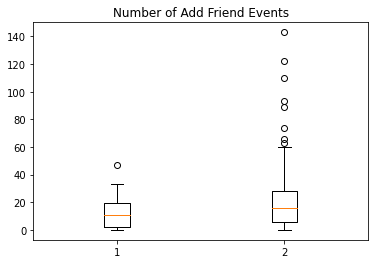

In [55]:
# find addfriend for users who churned vs others
churned = df_ml.select("addfriend").where(df_ml["churn"] == 1).toPandas()["addfriend"].values
stayed = df_ml.select("addfriend").where(df_ml["churn"] == 0).toPandas()["addfriend"].values

# plot
data = [churned, stayed]
fig, ax = plt.subplots()
ax.set_title('Number of Add Friend Events')
ax.boxplot(data)


plt.show()

Plot all numerical columns distributions:

### Conclusions

There is a difference in the distributions of those features between customers who churned and the others:

* The mean values of the average number of events and songs per day are lower for the customers who churned.
* The mean values of thumbs up, thumbs down and add friend events are lower for the customers who churned.

__This may also mean that the ones who churned were not very active__



# Modeling

## `1.` Split into Train, Test and Validations Sets:

In [56]:
# split into train, test and validation sets (60% - 20% - 20%)
df_ml = df_ml.withColumnRenamed("churn", "label")

train, test_valid = df_ml.randomSplit([0.6, 0.4], seed = 42)
test, validation = test_valid.randomSplit([0.5, 0.5], seed = 42)

## `2.` Create Machine Learning Pipelines:

 `2.1` Random Forest Classifier:

In [1]:
# index and encode categorical features gender, level and state

stringIndexerGender = StringIndexer(inputCol="gender", outputCol="genderIndex", handleInvalid = 'skip')
stringIndexerLevel = StringIndexer(inputCol="last_level", outputCol="levelIndex", handleInvalid = 'skip')
stringIndexerState = StringIndexer(inputCol="last_state", outputCol="stateIndex", handleInvalid = 'skip')

encoder = OneHotEncoder(inputCols=["genderIndex", "levelIndex", "stateIndex"],
                                       outputCols=["genderVec", "levelVec", "stateVec"],
                                handleInvalid = 'keep')

# create vector for features
features = ['genderVec', 'levelVec', 'stateVec', 'days_active', 'avg_songs', 'avg_events', 'thumbs_up', 'thumbs_down', 'addfriend']
assembler = VectorAssembler(inputCols=features, outputCol="features")

# initialize random forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, rf])

NameError: name 'StringIndexer' is not defined

In [60]:
model = pipeline.fit(train)

In [864]:
pred_train = model.transform(train)
pred_test = model.transform(test)

In [865]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.8273381294964028


In [866]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 1.0


Tune parameters for Random Forest classifier:

In [897]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .build()

In [898]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [899]:
cvModel = crossval.fit(train)

In [901]:
bestModel = cvModel.bestModel

In [902]:
pred_test = bestModel.transform(test)

predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.4


 `2.2` Logistic Regression classifier:

In [880]:
# initialize logistic regression
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, lr])

In [881]:
model = pipeline.fit(train)
pred_train = model.transform(train)
pred_test = model.transform(test)

In [882]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.7697841726618705


In [883]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 1.0


 `2.3` Gradient-boosted tree classifier:

In [887]:
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

# assemble pipeline
pipeline = Pipeline(stages = [stringIndexerGender, stringIndexerLevel, stringIndexerState, encoder, assembler, gbt])

In [888]:
model = pipeline.fit(train)
pred_train = model.transform(train)
pred_test = model.transform(test)

In [889]:
predictionAndLabels = pred_train.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on train dataset is %s" % metrics.fMeasure())

F1 score on train dataset is 0.9856115107913669


In [890]:
predictionAndLabels = pred_test.rdd.map(lambda lp: (float(lp.prediction), float(lp.label)))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# F1 score
print("F1 score on test dataset is %s" % metrics.fMeasure())

F1 score on test dataset is 0.9333333333333333


# Conclusion

In this notebook we went through the process from data exploration to modeling.
<b>Mini dataset is too small (test and validation sets have only 15 records), so we can't really evaluate models. To be able to evaluate models we should user medium dataset or the whole dataset.